In [2]:
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def f(x):
    return 3*x**2 - 4*x + 5

In [9]:
f(3.0)

20.0

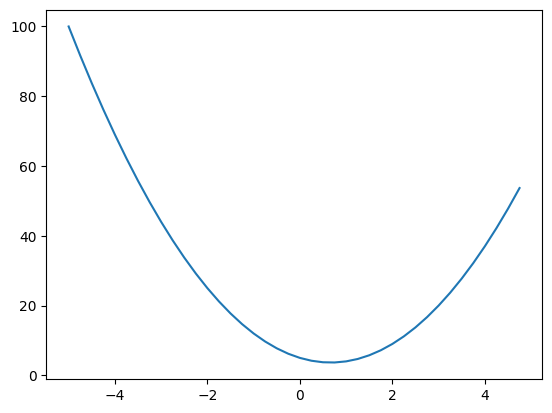

In [14]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [28]:
h = 0.00000000000001
x = -3.0
(f(x+h) - f(x))/h

-22.737367544323206

In [594]:
class Value: 

    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # 0 => changing this variable, would not change the Loss function
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self): 
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) # to solve for a * 2 or a + 2
        out = Value(self.data * other.data, (self, other), '*')

        
        def backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self, ), f'^({other})')

        def backward():
            self.grad += (other * (self.data ** (other - 1))) * (out.grad)
        out._backward = backward

        return out

    def __neg__(self, other): # -self
        return self * -1

    def __sub__(self, other): # a - b = a + (-1 * b)
        return self + (-other)

    def __rmul__(self, other): # other * self | to solve for 2 * a
        return self * other

    def __radd__(self, other): # other + self | to solve for 2 + a
        return self + other

    def __truediv(self, other):
        return self * other ** -1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = backward
    
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def backward():
            self.grad += out.data * out.grad
        out._backward = backward
    
        return out

    def back_propogate(self):
        topo = []
        visited = set()

        def topo_sort(v):
            visited.add(v)
            for u in v._prev:
                if u not in visited:
                    topo_sort(u)            
            topo.append(v)

        topo_sort(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        
    

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * a; L.label ='L'
n = L.tanh()
n

Value(data=0.9999997749296758)

In [595]:
from graphviz import Digraph


def trace(root):
    # build a set of all nodes and edges in a graph 
    nodes, edges = set(), set()

    def dfs(v):
        nodes.add(v)
        for u in v._prev:
            edges.add((u, v))
            if u not in nodes:
                dfs(u)
    
    dfs(root)
    return nodes, edges

def trace2(root):
    # build a set of all nodes and edges in a graph 
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for u in v._prev:
                edges.add((u, v))
                build(u)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right 
    nodes, edges = trace2(root)

    for n in nodes: 
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it 
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape ='record')
        if  n._op:
            # if this value is a result of some operation, create an op node for it 
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it 
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

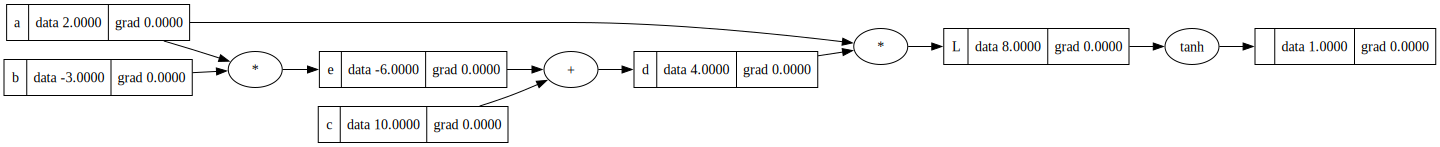

In [596]:
draw_dot(n)

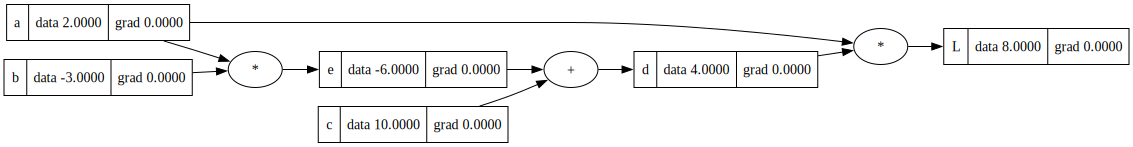

In [597]:
draw_dot(L)

In [598]:
import random


In [599]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer: 
    def __init__(self, nin, nout): #no of inputs = no of weights for each neuron, no of outputs = no of neurons in that layer
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = []
        for neuron in self.neurons: 
            ps = neuron.parameters()
            params.extend(ps)
        return params

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        for layer in self.layers: 
            ps = layer.parameters()
            params.extend(ps)
        return params


In [600]:
# x = [2.0, 3.0]
# n = Neuron(2)
# n(x)

In [601]:
# draw_dot(n(x))

In [606]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.7614707353461221)

In [607]:
xs = [
    [2.0, 3.0, -1.0], 
    [3.0, -1.0, 0.5], 
    [0.5, 1.0, 1.0], 
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [608]:
ypred = [n(x) for x in xs] 
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.531118621068768)

In [627]:
for k in range(100):
    # forward pass
    ypred = [n(x) for x in xs] 
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.back_propogate()

    # update
    for p in n.parameters():
        p.data += -0.9 * p.grad

    print(k, loss.data)
    

0 0.00016574304027987228
1 0.0001650216487666861
2 0.0001643063693042891
3 0.00016359712532402123
4 0.00016289384152344083
5 0.0001621964438403526
6 0.00016150485942749296
7 0.00016081901662777948
8 0.00016013884495024046
9 0.00015946427504643143
10 0.00015879523868750372
11 0.00015813166874177812
12 0.00015747349915284228
13 0.00015682066491821256
14 0.00015617310206847402
15 0.00015553074764690573
16 0.0001548935396895906
17 0.00015426141720602496
18 0.00015363432016011108
19 0.000153012189451655
20 0.00015239496689826868
21 0.0001517825952176761
22 0.00015117501801045177
23 0.00015057217974312682
24 0.00014997402573171367
25 0.00014938050212556436
26 0.00014879155589163308
27 0.00014820713479906208
28 0.00014762718740413851
29 0.00014705166303556844
30 0.000146480511780094
31 0.00014591368446842
32 0.00014535113266145728
33 0.00014479280863686017
34 0.00014423866537588252
35 0.00014368865655049596
36 0.0001431427365107985
37 0.00014260086027269905
38 0.00014206298350587278
39 0.0001

In [629]:
ypred = [n(x) for x in xs] 
ypred

[Value(data=0.995354853348193),
 Value(data=-0.9953533759476773),
 Value(data=-0.9942310621151166),
 Value(data=0.9937882619207431)]